In [1]:
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(0, '/Users/zhangming/Desktop/paper/code/halo_mass/')
import merger_tree_tools as mtt
import snapshot_tools as st
import halo_tools as ht
import galaxy_tools as gt

import random

from scipy.spatial import distance
from scipy.linalg import eig, eigh

from halomod import TracerHaloModel
import halomod
import hmf
print("halomod version: ", halomod.__version__)
print("hmf version:", hmf.__version__)

halomod version:  2.1.0
hmf version: 3.4.4


In [2]:
mtt=reload(mtt)
st=reload(st)
ht=reload(ht)
gt=reload(gt)

snap=st.SnapshotTools('/Users/zhangming/Desktop/paper/code/halo_mass/data/snapshot_064','HDF5')
halo=ht.HaloTools('/Users/zhangming/Desktop/paper/code/halo_mass/data/fof_subhalo_tab_064.hdf5','SubFind')
gal=gt.GalaxyTools('/Users/zhangming/Desktop/paper/code/halo_mass/data/galaxies.hdf5','SHARK')
tree=mtt.TreeTools('/Users/zhangming/Desktop/paper/code/halo_mass/data/trees_L62pt5_N270.hdf5','SubFind')

snap.ReadSnapshot()
halo.ReadHaloCatalogue()
gal.ReadGalaxyCatalogue()
tree.ReadMergerTreeCatalogue()

Reading data from /Users/zhangming/Desktop/paper/code/halo_mass/data/snapshot_064.hdf5
Reading data from /Users/zhangming/Desktop/paper/code/halo_mass/data/galaxies.hdf5
<KeysViewHDF5 ['bh_accretion_rate_hh', 'bh_accretion_rate_sb', 'cnfw_subhalo', 'cooling_rate', 'descendant_id_galaxy', 'id_galaxy', 'id_halo', 'id_halo_tree', 'id_subhalo', 'id_subhalo_tree', 'l_x', 'l_y', 'l_z', 'lambda_subhalo', 'm_bh', 'matom_bulge', 'matom_disk', 'mean_stellar_age', 'mgas_bulge', 'mgas_disk', 'mgas_metals_bulge', 'mgas_metals_disk', 'mhot', 'mhot_metals', 'mlost', 'mlost_metals', 'mmol_bulge', 'mmol_disk', 'mreheated', 'mreheated_metals', 'mstars_bulge', 'mstars_bulge_diskins_assembly', 'mstars_bulge_mergers_assembly', 'mstars_burst_diskinstabilities', 'mstars_burst_mergers', 'mstars_disk', 'mstars_metals_bulge', 'mstars_metals_bulge_diskins_assembly', 'mstars_metals_bulge_mergers_assembly', 'mstars_metals_burst_diskinstabilities', 'mstars_metals_burst_mergers', 'mstars_metals_disk', 'mvir_hosthalo

In [3]:
ipick=np.logical_and(snap.pos[:,2]<40,snap.pos[:,2]>20)              # particle  # 0-125
jpick=np.logical_and(halo.GroupPos[:,2]<40,halo.GroupPos[:,2]>20)    # halo
kpick=np.logical_and(gal.pos[:,2]<40,gal.pos[:,2]>20)                # galaxy
lpick=np.logical_and(halo.SubPos[:,2]<40,halo.SubPos[:,2]>20)        # subhalo

print(len(ipick), len(jpick), len(kpick), len(lpick))

19683000 24590 27011 29181


In [4]:
# calculate velocity dispersion and estimate the halo mass M_sigma
def cal_sigma_Msigma(velocities, R):
    G = 43
    sigx = np.std(velocities[:,0])
    sigy = np.std(velocities[:,1])
    sigz = np.std(velocities[:,2])
    sigma = np.sqrt(sigx**2+sigy**2+sigz**2)    # velocity dispersion
    Msigma = 2 * (sigma**2) * R / G             # M_sigma
    return sigma, Msigma
    
# calculate kinetic energy and potential energy
def calc_kinetic_energy(positions, masses, velocities):
    speeds = np.linalg.norm(velocities, axis=1)
    kinetic_energy = 0.5 * masses * speeds**2
    return np.sum(kinetic_energy)

def calc_potential_energy(positions, masses):
    G = 43    
    N = positions.shape[0]
    potential_energy = np.zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            r = np.linalg.norm(positions[j]-positions[i])
            potential_energy[i,j] = -G*masses*masses/r
            potential_energy[j,i] = potential_energy[i,j]
    return np.sum(potential_energy)/2.0

# calculate 1D velocity dispersion of line of sight
def cal_veldisp_1d(velocities):
    los_sum=0
    for j in range(10):
        a1=random.uniform(0,1)
        a2=random.uniform(0,1)
        a3=random.uniform(0,1)
        aa=[a1/np.sqrt(a1**2+a2**2+a3**2),a2/np.sqrt(a1**2+a2**2+a3**2),a3/np.sqrt(a1**2+a2**2+a3**2)]
        los_sum = np.std(velocities[:,0]*aa[0]+velocities[:,1]*aa[1]+velocities[:,2]*aa[2])+los_sum
    los_mean=los_sum/10
    return los_mean

# calculate the major axis, minor axis, intermediate axis and their projected velocity dispersion
def calc_axis_projv(positions, velocities):
    center = np.average(pos[keep_ids], axis=0)
    relative_positions = pos[keep_ids] - center
    
    # Calculating the inertia tensor
    relative_positions = relative_positions[np.all(np.isfinite(relative_positions), axis=1)]
    inertia_tensor = np.zeros((3, 3))
    for i in range(len(relative_positions)):
        r = relative_positions[i]
        inertia_tensor += np.outer(r, r)
    eigenvalues, eigenvectors = eig(inertia_tensor)
    major_axis = eigenvectors[:, np.argmax(eigenvalues)]
    minor_axis = eigenvectors[:, np.argmin(eigenvalues)]
    intermediate_axis = eigenvectors[:, np.argsort(eigenvalues)[1]]
    
    # Axial ratio
    major_distances = np.abs(relative_positions @ major_axis)
    minor_distances = np.abs(relative_positions @ minor_axis)
    intermediate_distances = np.abs(relative_positions @ intermediate_axis)
    a_major = np.average(major_distances)
    b_inter = np.average(intermediate_distances)
    c_minor = np.average(minor_distances)
    
    # velocity dispersion
    relative_velocities = velocities
    major_velocities = relative_velocities @ major_axis
    minor_velocities = relative_velocities @ minor_axis
    intermediate_velocities = relative_velocities @ intermediate_axis

    major_dispersion = np.sqrt(np.var(major_velocities))
    intermediate_dispersion = np.sqrt(np.var(intermediate_velocities))
    minor_dispersion = np.sqrt(np.var(minor_velocities))
    return a_major, b_inter, c_minor, major_dispersion, intermediate_dispersion, minor_dispersion

In [5]:
### Using particles to calculate verlocity dispersion and Msigma

# G=43    # unit：(km/s)^2 Mpc/ 1e10*M_sun

# Particle=[]
# # for i in range(10):
# for i in range(len(halo.GroupPos[jpick])):
#     pos=snap.pos[ipick]-halo.GroupPos[jpick][i]
#     vel=snap.vel[ipick]-halo.GroupVel[jpick][i]
#     r=np.sqrt(pos[:,0]**2+pos[:,1]**2+pos[:,2]**2)
#     keep_ids=np.where(r<halo.GroupR200[jpick][i])
    
#     number = len(vel[keep_ids])                             # the number of particle in halo
#     m200 = halo.GroupM200[jpick][i]*1                       # M200
#     sigma200 = np.sqrt(G * halo.GroupM200[jpick][i] / 2 / (halo.GroupR200[jpick][i] )  )  # sigma200
#     r200 = round(halo.GroupR200[jpick][i]*1,4)              # R200

#     sigma, msigma = cal_sigma_Msigma(vel[keep_ids], halo.GroupR200[jpick][i])   # velocity dispersion and M_sigma
    
#     los_mean = cal_veldisp_1d(vel[keep_ids])                # velocity dispersion of line of sight
    
#     a_major, b_inter, c_minor, major_dispersion, intermediate_dispersion, minor_dispersion = calc_axis_projv(pos[keep_ids], vel[keep_ids])
    
#     # offset
#     for k in range(10):
#         r=np.sqrt(pos[:,0]**2+pos[:,1]**2+pos[:,2]**2)
#         keep_ids=np.where(r<halo.GroupR200[jpick][i]*(1-0.1*k))
#         cen=np.mean(pos[keep_ids],axis=0)+halo.GroupPos[jpick][i]
#         pos=snap.pos[ipick]-cen
    
#     pos2=snap.pos[ipick]-halo.GroupPos[jpick][i]
#     r=np.sqrt(pos2[:,0]**2+pos2[:,1]**2+pos2[:,2]**2)
#     keep_ids=np.where(r<halo.GroupR200[jpick][i]) 
#     pcen=np.mean(pos[keep_ids],axis=0)+halo.GroupPos[jpick][i]
#     off = pcen-cen
#     offset = np.sqrt(off[0]**2 + off[1]**2 + off[2]**2)
#     offset_log = np.log10(offset)                           # offset
    
#     Particle.append([round(i,0), round(number,0), round(m200,4), round(sigma200,4), r200, round(sigma,4),
#                      round(msigma,4),round(los_mean,4), round(offset,5), round(offset_log,5),
#                      round(a_major,5),round(b_inter,5),round(c_minor,5),
#                      round(major_dispersion,5),round(intermediate_dispersion,5),round(minor_dispersion,5)])  
# Labels = ['No.', 'Number_particles', 'M200', 'sigma200','R200', 'Sigma','M_sigma','Sigma_LoS','Offset','offset_log',
#           'a_major', 'b_inter', 'c_minor', 'major_dispersion', 'intermediate_dispersion', 'minor_dispersion'] 
# Particle = np.vstack([Labels, Particle])
# np.savetxt('./results/Particle2040.txt', Particle, fmt='%s')

In [6]:
### Using subhalos to calculate verlocity dispersion and Msigma

# Subhalo=[]
# # for i in range(20):
# for i in range(len(halo.GroupPos[jpick])):
#     subpos = halo.SubPos[lpick]-halo.GroupPos[jpick][i]
#     subvel= halo.SubVel[lpick]-halo.GroupVel[jpick][i]
#     rr=np.sqrt(subpos[:,0]**2+subpos[:,1]**2+subpos[:,2]**2)
#     subkeep_ids=np.where(rr<halo.GroupR200[jpick][i])
    
#     number = len(subvel[subkeep_ids])              # the number of particle in halo
#     m200 = halo.GroupM200[jpick][i]*1              # M200
    
#     sigma200 = np.sqrt(G * halo.GroupM200[jpick][i] / 2 / (halo.GroupR200[jpick][i] )  )  # sigma200
#     r200=round(halo.GroupR200[jpick][i]*1,4)       # R200
    
#     sigma, msigma = cal_sigma_Msigma(subvel[subkeep_ids], halo.GroupR200[jpick][i])   # velocity dispersion and M_sigma
    
#     los_mean = cal_veldisp_1d(subvel[subkeep_ids])                # velocity dispersion of line of sight
    
#     Subhalo.append([round(i,0), round(number,0), round(m200,4), round(sigma200,4), r200, round(sigma,4),
#                      round(msigma,4),round(los_mean,4)]) 

# Labels = ['No.', 'Number', 'M200', 'sigma200','R200', 'Sigma','M_sigma','Sigma_LoS']
# Subhalo = np.vstack([Labels, Subhalo])
# np.savetxt('./results/Subhalo2040.txt', Subhalo, fmt='%s')

In [7]:
### Using galaxies to calculate verlocity dispersion and Msigma

# Galaxy=[]
# # for i in range(20):
# for i in range(len(halo.GroupPos[jpick])):
#     galpos = gal.pos[kpick]-halo.GroupPos[jpick][i]
#     galvel= gal.vel[kpick]-halo.GroupVel[jpick][i]
#     rrr=np.sqrt(galpos[:,0]**2+galpos[:,1]**2+galpos[:,2]**2)
#     galkeep_ids=np.where(rrr<halo.GroupR200[jpick][i])
  
#     number = len(galvel[galkeep_ids])
#     m200 = halo.GroupM200[jpick][i]*1    # M200
#     sigma200 = np.sqrt(G * halo.GroupM200[jpick][i] / 2 / (halo.GroupR200[jpick][i] )  )  # sigma200
#     r200=round(halo.GroupR200[jpick][i]*1,4)  # R200
    
#     sigma, msigma = cal_sigma_Msigma(galvel[galkeep_ids], halo.GroupR200[jpick][i])   # velocity dispersion and M_sigma
    
#     los_mean = cal_veldisp_1d(galvel[galkeep_ids])                # velocity dispersion of line of sight
    
#     Galaxy.append([round(i,0), round(number,0), round(m200,2), round(sigma200,2), r200, round(sigma,2),
#                      round(msigma,2),round(los_mean,2)])

# Labels = ['No.', 'Number', 'M200', 'sigma200','R200', 'Sigma','M_sigma','Sigma_LoS']
# Galaxy = np.vstack([Labels, Galaxy])
# # np.savetxt('./results/Galaxy2040.txt', Galaxy, fmt='%s')

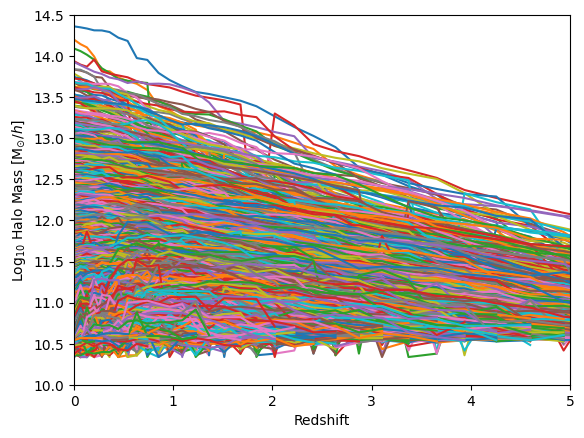

In [8]:
halo_list=np.where(halo.GroupNsubs>0)[0]
main_subhalo_list=halo.GroupFirstSub[halo_list]
plt.xlim([0,5])
plt.ylim([10,14.5])
plt.xlabel("Redshift")
plt.ylabel(r"Log$_{10}$ Halo Mass [M$_{\odot}/h$]")
formation = []
Formation = []
formation_redshift=np.array([])
halo_mass=np.array([])
halo_vd=np.array([])
alpha03=np.array([])
for main_subhalo_id in main_subhalo_list:
    redshift,mass,m200,vel_disp,group_number,subhalo_number,zform,alpha=tree.TrackMainHaloProgenitor(main_subhalo_id,64)
    if len(mass)>0:
        formation_redshift=np.append(formation_redshift,zform)
        halo_mass=np.append(halo_mass,mass[0])
        halo_vd=np.append(halo_vd,vel_disp[0])
        alpha03=np.append(alpha03,alpha)
        formation.append([mass[0],m200[0],vel_disp[0],group_number[0],subhalo_number[0],zform,alpha])
        plt.plot(redshift,np.log10(mass)+10)  
# print(form)
Labels = ['mass', 'M200', 'vel_disp','group_number', 'subhalo_number','zform','alpha']  
Formation = np.vstack([Labels, formation])
np.savetxt('./results/formation.txt', Formation, fmt='%s')